In [186]:
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from time import time

In [187]:
folders = [x[0] for x in os.walk('images')][1:]

In [188]:
images = []
for folder in folders:
    with open(folder+'//filelist_LBP.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for img_name, left, top, right, bottom, new_size_y, new_size_x in reader:
            img = Image.open(folder+'//'+img_name).resize((int(new_size_y), int(new_size_x))).crop((int(left), int(top), int(right), int(bottom))).resize((100,100))
            
            # some images are black and white, for PCA to work correctly need to convert those to rgb
            if (len(np.array(img).shape) != 3 or np.array(img).shape[2] != 3):
                rgbimg = Image.new("RGB", img.size)
                rgbimg.paste(img)
                images.append(rgbimg)
            else:
                images.append(img)
            if (len(np.array(images[-1]).shape) != 3 or np.array(images[-1]).shape[2] != 3):
                print ("Image was not processed correctly " + folder + '//' + img_name)

Showing few random faces from the dataset.

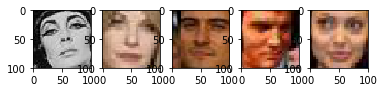

In [189]:
num_faces = 5

for i in range(1, num_faces+1):
    img = random.choice(images)
    plt.subplot(2, num_faces, i)
    plt.imshow(img)

In [190]:
import glob
import os 
from os.path import join as pjoin
import cv2

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def resize(img, imgshape):
    return cv2.resize(img, (imgshape[1], imgshape[0]))

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')

def get_data_matrix(dataset_path, imgshape, m=None, m_start=0, m_freq=1, color=True, ext='jpg'):
    """
    imgshape -- np.array([h, w]) -- spatial size of the frames
    m -- number of frames,
         if None then all the images in dataset_path will be used
    m_start -- number of the frame from which data matrix starts
    m_freq -- frequency of frames to collect in data matrix
    """
    imgpaths = sorted(glob.glob(pjoin(dataset_path, '*.{}'.format(ext))))
    m = len(imgpaths) 
    if color:
        imgshape = np.array([*imgshape, 3])
        X = resize(imread(imgpaths[m_start]), imgshape).reshape((-1,1))
        for imgpath in imgpaths:
            img = resize(imread(imgpath), imgshape)
            img_vec = img.reshape((-1,1))
            X = np.hstack((X, img_vec))
    return X


In [191]:
def stack_images(matrices, k=1, imgshape=np.array([100, 100, 3]), captions=None, leftcaption=None):
    """
        matrices -- (N, *imgshape, k) array,
                    where N is the number of `matrices`,
                          k is the number of images in each `matrix`
    """
    assert imgshape is not None, 'Please specify the spatial size of the frames (imgshape)'
    k = min(matrices[0].shape[-1], k)
    N = len(matrices)
    num_cols, num_rows = N, 1
    if captions is None:
        captions = ['']*N
    matrices_ = []
    if len(imgshape) == 2:
        print('here')
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(2,0,1)[:k]
#             print(M.shape)
            matrices_.append(M)
    else:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(3,0,1,2)[:k]
#             print(M.shape)
            matrices_.append(M)
    for k_ in range(k):
        for i in range(N):
            plt.subplot(num_rows, num_cols, i+1)
            imshow(matrices_[i][k_])
            plt.title(captions[i])
            if i == 0:
                plt.title(leftcaption, loc='left')
        plt.show()

### Implementing eigenfaces with SVD

Implement eigenfaces using singular value decomposition (SVD). Remember to represent the images properly and account for the color.

In [206]:
# =============== TODO: Your code here ===============
# Represent the images as a matrix for SVD decompotision.
dataset_path = random.choice(folders)
imgshape = np.array([100, 100]) # spatial size of the frame

X_input = get_data_matrix(dataset_path, imgshape)
print(X_input.shape)
# ====================================================

(30000, 200)


In [207]:
from scipy import linalg as LA

def eigenfaces_from_SVD(M, k, color=True):
    """
    k -- rank of the low-rank matrix approximation
    """
    t0 = time()
    U, S, VT = LA.svd(M, full_matrices=False)

    U = U[:,:k]

    eigenfaces = ((U - U.min()) 
              * (1/(U.max() - U.min()) * 255)).astype('uint8')
    
    print("SVD: eigenfaces found in %0.3fs" % (time() - t0))
    
    return eigenfaces

def eigenfaces_from_PCA(M, k):
    # based on 
    # https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

    from sklearn.decomposition import PCA
    t0 = time()
    num_eigenfaces = 10
    pca = PCA(n_components=num_eigenfaces, svd_solver='randomized',
              whiten=True).fit(X.transpose())
    evecs = pca.components_
    eigenfaces = ((evecs - evecs.min()) 
                      * (1/(evecs.max() - evecs.min()) * 255)).astype('uint8')
    print("PCA: eigenfaces found in %0.3fs" % (time() - t0))
    return eigenfaces

def eigenfaces_custom(M, k):
    t0 = time()
    mean_col = np.sum(M, axis=1) / M.shape[1]
    for j in range(M.shape[1]):
        M[:, j] = (M[:, j]) - mean_col
        
    # to speed up it's better to use covmat [MxM] rather that [NxN]
    # http://blog.manfredas.com/eigenfaces-tutorial/
    C = np.matmul(M.transpose(), M)
    C = C / M.shape[1]

    evalues, evectors = np.linalg.eig(C)

#     sort evalues
    sort_indices = evalues.argsort()[::-1]
    evalues = evalues[sort_indices]
    evectors = evectors[:, sort_indices]  
    
    evalues = evalues[0:k]
    evectors = evectors[:,0:k]
    evectors = np.matmul(M, evectors)
#     print(M.shape, evectors.shape)
    norms = np.linalg.norm(evectors, axis=0)
    evectors = evectors / norms
    
    eigenfaces = ((evectors - evectors.min()) 
                  * (1/(evectors.max() - evectors.min()) * 255)).astype('uint8')
    print("Custom algorithm: eigenfaces found in %0.3fs" % (time() - t0))
    return eigenfaces

In [208]:
# =============== TODO: Your code here ===============
# Implement eigenfaces using singular value decomposition (SVD). 
# Remember to represent the images properly and account for the color.

# here I run three different methods to compare eigenfaces form each of them

eigenfaces_from_SVD = eigenfaces_from_SVD(X_input, 10)

eigenfaces_from_PCA = eigenfaces_from_PCA(X_input, 10)

eigenfaces = eigenfaces_custom(np.copy(X_input), 10)

SVD: eigenfaces found in 0.243s
PCA: eigenfaces found in 0.089s
Custom algorithm: eigenfaces found in 4.277s


Visualize 10 eigenfaces associated with the highest eigenvalues.

Eigenfaces from SVD


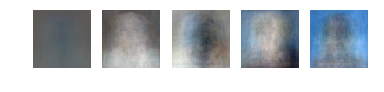

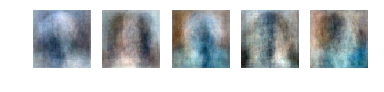

-------------------
Eigenfaces from PCA


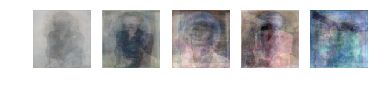

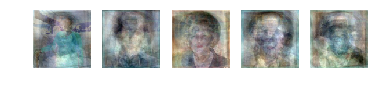

-------------------
Eigenfaces from custom algorithm


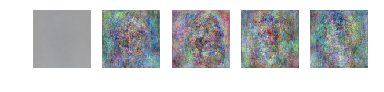

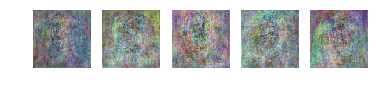

-------------------


In [209]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces associated with the highest eigenvalues.
print("Eigenfaces from SVD")
stack_images((eigenfaces_from_SVD[:, 0], eigenfaces_from_SVD[:, 1], eigenfaces_from_SVD[:, 2], eigenfaces_from_SVD[:, 3], eigenfaces_from_SVD[:, 4]))
stack_images((eigenfaces_from_SVD[:, 5], eigenfaces_from_SVD[:, 6], eigenfaces_from_SVD[:, 7], eigenfaces_from_SVD[:, 8], eigenfaces_from_SVD[:, 9]))
print("-------------------")
print("Eigenfaces from PCA")
stack_images((eigenfaces_from_PCA[0], eigenfaces_from_PCA[1], eigenfaces_from_PCA[2], eigenfaces_from_PCA[3], eigenfaces_from_PCA[4]))
stack_images((eigenfaces_from_PCA[5], eigenfaces_from_PCA[6], eigenfaces_from_PCA[7], eigenfaces_from_PCA[8], eigenfaces_from_PCA[9]))
print("-------------------")
print("Eigenfaces from custom algorithm")
stack_images((eigenfaces[:, 0], eigenfaces[:, 1], eigenfaces[:, 2], eigenfaces[:, 3], eigenfaces[:, 4]))
stack_images((eigenfaces[:, 5], eigenfaces[:, 6], eigenfaces[:, 7], eigenfaces[:, 8], eigenfaces[:, 9]))
print("-------------------")
# ====================================================

### Implementing eigenfaces with variance maximization

As you have noticed, SVD could be quite slow if the number of faces is large. If the number of faces exceeds 50k, which is not a large dataset according to the modern standards, doing SVD is not possible directly and you have to use iterative methods for computing eigenfaces.

Here, you are going to calculate 10 eigenfaces by maximizing variance as stated in the lecture notes.

In [210]:
# =============== TODO: Your code here ===============
# Calculate 10 eigenfaces iteratively by variance maximization.
def first_eigs(M):
    n_iters = 200000
    return power_iteration(M, n_iters)

def power_iteration(M, n_iters):
    tol = 10**(-9)
    
    vec = np.random.rand(M.shape[0])
    val_old = np.dot(np.transpose(vec), M.dot(vec)) / np.dot(np.transpose(vec), vec)

    for i in range(n_iters):
        vec_temp = M.dot(vec)
        vec_temp_norm = np.linalg.norm(vec_temp)
        vec = vec_temp / vec_temp_norm
        
#         vec = M.dot(vec) / np.linalg.norm(vec)
        val = np.dot(np.transpose(vec), M.dot(vec)) / np.dot(np.transpose(vec), vec)
    
        if (abs(val - val_old) / val) < tol:
            return val, vec
        val_old = val
        
    return val, vec

def eigenfaces_power_iterations(M, k):
    t0 = time()
    mean_col = np.sum(M, axis=1) / M.shape[1]
    for j in range(M.shape[1]):
        M[:, j] = (M[:, j]) - mean_col
        
    C = np.matmul(M.transpose(), M)
    C = C / M.shape[1]

    evectors = np.zeros((C.shape[0], k))
    
    for i in range(k):    
        evalue, evector = first_eigs(C)

        temp = np.zeros((C.shape[0], 1))
        temp[:, 0] = evector
        
        C = C - evalue * np.matmul(temp, temp.T)
        evectors[:, i] = evector
    
    evectors = np.matmul(M, evectors)
    norms = np.linalg.norm(evectors, axis=0)
    evectors = evectors / norms
    eigenfaces = ((evectors - evectors.min()) 
                  * (1/(evectors.max() - evectors.min()) * 255)).astype('uint8')

    print("Power iterations algorithm: eigenfaces found in %0.3fs" % (time() - t0))
    return eigenfaces

eigenfaces_power = eigenfaces_power_iterations(X_input, 10)

Power iterations algorithm: eigenfaces found in 4.532s


Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces. 

Power iterations algorithm: eigenfaces found in 4.459s
Eigenfaces from custom algorithm


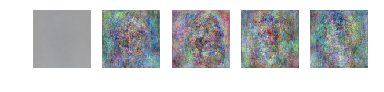

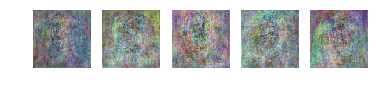

-------------------
Eigenfaces from power iterations algorithm


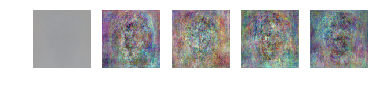

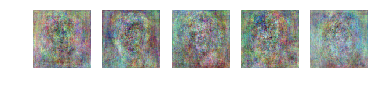

-------------------


In [211]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces.
eigenfaces2 = eigenfaces_power_iterations(X_input, 10)
print("Eigenfaces from custom algorithm")
stack_images((eigenfaces[:, 0], eigenfaces[:, 1], eigenfaces[:, 2], eigenfaces[:, 3], eigenfaces[:, 4]))
stack_images((eigenfaces[:, 5], eigenfaces[:, 6], eigenfaces[:, 7], eigenfaces[:, 8], eigenfaces[:, 9]))
print("-------------------")
print("Eigenfaces from power iterations algorithm")
stack_images((eigenfaces_power[:, 0], eigenfaces_power[:, 1], eigenfaces_power[:, 2], eigenfaces_power[:, 3], eigenfaces_power[:, 4]))
stack_images((eigenfaces_power[:, 5], eigenfaces_power[:, 6], eigenfaces_power[:, 7], eigenfaces_power[:, 8], eigenfaces_power[:, 9]))
print("-------------------")
# ====================================================

<b>Conclusion:</b> I used power method to get 10 biggest eigenvalues with appropriate eigenvectors. Power method shows comparable time execution with previous method (when we found all eigenvalues). Eigenfaces are pretty similar in both methods.